# Closing the loop with a Proportional-Derivative controller

We have seen in the previous notebook how to do a simple control loop that read sensors and applied torque commands. However, we did not use the sensor measurements to compute the torque commands.

<img src="images/control_loop.png" width=600>

Now we would like to do our first closed-loop controller. We will design a simple Proportional-Derivative (PD) position controller. The goal of the controller is to compute a command that will move the joints of the robot to a desired position.

Assume that we want the first joint, with measurement position $\theta$, to move to the desired position $\theta_{des}$. The idea is to apply a command proportional to the error between the measured and desired position (the P in PD controller). The  error is
$$\textrm{error} = (\theta_{des} - \theta)$$  and
the desired torque to apply to the join will be $\tau = P \cdot \textrm{error} = P (\theta_{des} - \theta)$ where $P$ is a constant.

However, when using only a term proportional to the position, the controller will tend to create oscillations and get easily unstable (you can try!). It is then a good idea to add a term proportional to the time derivative of the error (the D term), i.e. proportional to the velocity.
The time derivative of the error is
$$\frac{d}{dt}\textrm{error} = \frac{d}{dt}(\theta_{des} - \theta) =  \dot{\theta}_{des} - \dot{\theta}$$

So a PD controller takes the general form
$\tau = P (\theta_{des} - \theta) + D (\dot{\theta}_{des} - \dot{\theta})$
where $P$ and $D$ are positive numbers called the **PD gains**
Intuitively it applies a command that tries to follow at the same time a desired position and a desired velocity (which dampens fast oscillations).

When we want to be in a static position, $\dot{\theta}_{des}$ will be 0, but if we want to follow a trajectory $\theta_{des}(t)$ which varies over time, the derivative $\dot{\theta}_{des}(t)$ will not be 0 anymore.

In [1]:
#setup nice plotting
%matplotlib notebook

# we import useful libraries including numpy for easy algebra and matplot for plotting
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

# we import the helper class to work with either the simulation or real robot
use_real_robot = False

if use_real_robot:
    from nyu_finger import NYUFingerReal    
else:
    from nyu_finger_simulator import NYUFingerSimulator
    


pybullet build time: Dec  1 2021 18:33:43


In [2]:
## if we are using the real robot
if use_real_robot:
    # Triggers the real robot
    # Don't forget to turn on the robot first !!!
    robot = NYUFingerReal()
    
    # Make sure that the motor number matches that on the robot
    motor_number = np.array([3,2,0])
    robot.initialize('eth4', motor_number)
    
## if we are using the simulation
else:
    # we can now create a robot simulation
    robot = NYUFingerSimulator()

In [3]:
# here is an example of a simple PD controller

# we reset the simulation
if not use_real_robot:
    robot.reset_state([0.,0.,0.])

# we simulate for 5 seconds
run_time = 10.
dt = 0.001
num_steps = int(run_time/dt)

# the PD gains - they are constant so we define them outside the control loop
P = np.array([1.5, 1.5, 1.5]) * 2/3
D = np.array([0.1, 0.1, 0.1]) * .5

# the desired position - also constants
q_des = np.array([0.,0.,0.8*np.sin(np.pi*0)])
dq_des = np.zeros_like(q_des) # the desired velocity here is 0

## we allocate a few vectors to collect data while we do the simulation
measured_positions = np.zeros([num_steps,3])
measured_velocities = np.zeros_like(measured_positions)
desired_torques = np.zeros_like(measured_positions)
time = np.zeros([num_steps])


## this is our main control loop ##
## we do the loop for num_steps ##
for i in range(num_steps):
    # get the current time
    time[i] = dt * i
    q_des = np.array([.5*np.cos(np.pi*time[i]),0.,0.8*np.sin(np.pi*time[i])])

    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot.get_state()
    
    # we store these values for later use
    measured_positions[i,:] = q
    measured_velocities[i,:] = dq
    
    error = q_des - q # the position error for all the joints (it's a 3D vector)
    d_error = dq_des-dq # the velocity error for all the joints
    
    # we compute the desired torques as a PD controller
    joint_torques = P * error + D * d_error
    desired_torques[i,:] = joint_torques
    
    # we send them to the robot and do one simulation step
    robot.send_joint_torque(joint_torques)
    robot.step()    

<IPython.core.display.Javascript object>


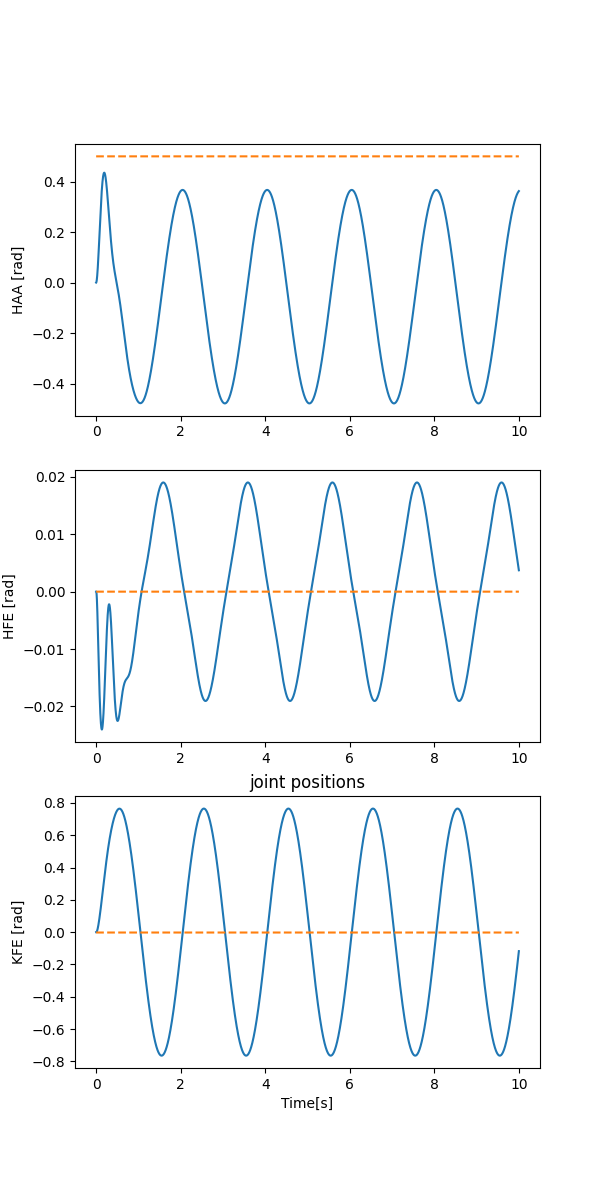

<IPython.core.display.Javascript object>


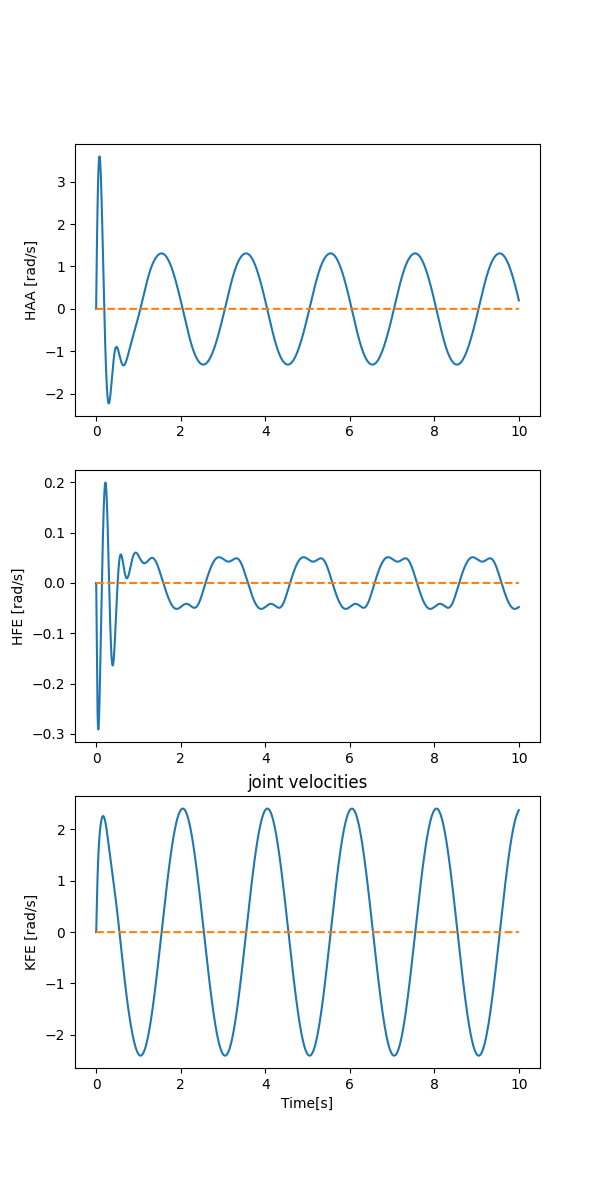

Text(0.5, 1.0, 'joint velocities')

In [4]:
# we plot the measured position and velocities of all the joints
# and add the desired values
time = np.linspace(0., run_time, num=num_steps)
joint_names = ["HAA", "HFE", "KFE"]
plt.figure(figsize=[6, 12])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(time, measured_positions[:,i])
    plt.plot(time, np.ones_like(time)*q_des[i],'--')
    plt.ylabel(joint_names[i] + ' [rad]')
plt.xlabel('Time[s]')
plt.title('joint positions')

plt.figure(figsize=[6, 12])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(time, measured_velocities[:,i])
    plt.plot(time, np.ones_like(time)*dq_des[i],'--')
    plt.ylabel(joint_names[i] + ' [rad/s]')
plt.xlabel('Time[s]')
plt.title('joint velocities')

## Questions:
(submit a pdf with detailed answers to these questions, including the plots through Brightspace)

1. Describe qualitatively what you observe when you increase/decrease P and D.

2. Tune the P and D gains to have a good tracking of the positions $[0,0,\frac{\pi}{2}]$ without any oscillations. The P and D gains need not be the same for different joints. What gains did you find? Plot the position and velocities of each joints as a function of time with these gains. (starting from the original initial robot configuration).

3. Use the PD controller to do the following task: keep the position of the first two joints fixed and follows the following position trajectory for the last joint $0.8 \sin(\pi t)$. Plot the results (positions and velocities as a function of time for all joints). Simulate for at least 10 seconds.

4. Do question 3. on the real robot.

5. Change the joint trajectories to get the robot to draw a circle in the air with its fingertip.